<a href="https://colab.research.google.com/github/emmayeh-0211/2021AI_dl/blob/main/03_transfer_learning_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [4]:
# download from google drive or upload file by yourself
!gdown --id '1ZrB69wSgzXLu8UZdPJb8hnB6K4eltcpu' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1ZrB69wSgzXLu8UZdPJb8hnB6K4eltcpu
To: /content/retina-dataset.zip
35.1MB [00:00, 164MB/s]


In [5]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [6]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/15351_left_0.jpeg


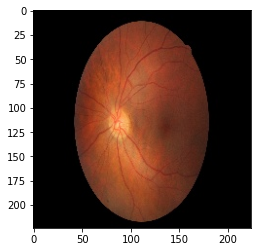

In [7]:
# 隨機找一張圖片給大家看
idx = np.random.randint(0, len(paths), size=1)[0]
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

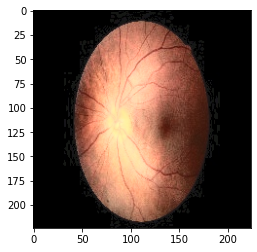

In [8]:
# 對圖片作前處理（根據資料本身是否需要）
# Histogram Equaliztion 以這個資料為例，是加深對比度
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [9]:
# 資料的答案是在檔名上，所以將檔名進行分割，將答案取出
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['44123_left_0.jpeg', '5758_right_1.jpeg', '27812_right_0.jpeg']
[0, 1, 0]


<BarContainer object of 3 artists>

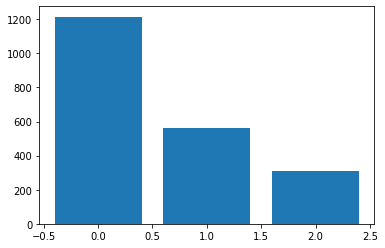

In [10]:
# Class distribution
# 有三類 0 1 2
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [11]:
# Method 1: 
# clear graph
tf.keras.backend.clear_session() # 先清空之前有搭建的任何模型

# 放入要使用的模型 EfficientNetB0
# (include_top=False)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# 後面接自己的設計的分類層
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# 把模型中某些層給Freeze，也就是把某些層的參數給固定住，方式如下
for l in base_model.layers:
    l.trainable = False

model = models.Model(base_model.input, predictions)

16711680/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

#### Prepare Data

In [16]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [17]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # preprocess by histogram equlization
        img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)
        # Applying equalize Hist operation on Y channel.
        y_eq = cv2.equalizeHist(y)
        img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)

        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        # 如果要用某個模型做transfer learning，就要follow該模型資料前處理的方式
        # 所以下面再會有一個.preprocess_input
        # 因為這是keras官方的模組，所以有把前處理定義好了，所以直接把.preprocess_input拿來用就好
        # 但如果不是這個，是自己的另外找其他人做的模型，就要研究該模型是否有對資料作前處理，做了什麼前處理
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot encoding
        return x_data, y_data
    else:
        return x_data

In [18]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val) # train 跟 val是有答案的，所以可以知道模型的成效
x_test = create_dataset(paths_test, test=True) # test是要來測試的，沒有答案

100%|██████████| 522/522 [00:00<00:00, 609.46it/s]


In [19]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Training

In [21]:
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, # 多元分類
              metrics=[metrics.categorical_accuracy])

In [23]:
logs = model.fit(x_train, y_train,
                batch_size=32,
                epochs=20,
                validation_data=(x_val, y_val))

Epoch 1/20
53/53 [==============================] - 39s 120ms/step - loss: 0.9229 - categorical_accuracy: 0.5797 - val_loss: 0.7531 - val_categorical_accuracy: 0.6699
Epoch 2/20
53/53 [==============================] - 5s 91ms/step - loss: 0.8433 - categorical_accuracy: 0.6091 - val_loss: 0.7798 - val_categorical_accuracy: 0.6675
Epoch 3/20
53/53 [==============================] - 4s 83ms/step - loss: 0.7924 - categorical_accuracy: 0.6403 - val_loss: 0.7112 - val_categorical_accuracy: 0.6914
Epoch 4/20
53/53 [==============================] - 4s 82ms/step - loss: 0.7726 - categorical_accuracy: 0.6559 - val_loss: 0.6795 - val_categorical_accuracy: 0.6986
Epoch 5/20
53/53 [==============================] - 4s 83ms/step - loss: 0.7556 - categorical_accuracy: 0.6589 - val_loss: 0.7056 - val_categorical_accuracy: 0.6866
Epoch 6/20
53/53 [==============================] - 4s 82ms/step - loss: 0.7373 - categorical_accuracy: 0.6715 - val_loss: 0.7171 - val_categorical_accuracy: 0.6890
Epoch 7/

#### Make Submission file

Kaggle: https://www.kaggle.com/c/retinopathy-classification-sai/data


In [25]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0
